In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats as stats
import matplotlib as mpl
import plot_utils

In [2]:
methods = {
    # 'n_3r1i': '3 dims\n1 answer',
    # 'n_1r1i': '1 dim\n1 answer',
    'n_1r10i': '1 dim\n10 answers',
    'n_1r20i': '1 dim\n20 answers',
    'n_1r50i': '1 dim\n50 answers',
    's_1r20i': '1 dim\n20 answers\n10 samples',
    'n_1r20i_numeric': '1 dim\n20 answers\nrating-only',
    's_1r20i_numeric': '1 dim\n20 answers\nrating-only\n10 samples',
}

In [3]:
measures = ('novelty', 'feasibility', 'value')

In [4]:
pearson = pd.DataFrame(columns=measures, dtype=float)
spearman = pd.DataFrame(columns=measures, dtype=float)

In [56]:
squid = []
rmsd = []
for method, name in methods.items():
    data = pd.read_excel(f'gpt-ratings/{method}-turbo.xlsx')
    for key in measures:
        if key == 'value':
            mask = (data[key]>0) & (data[key]<100_000)
        else:
            mask = data.index>=0
        spearman.loc[name, key] = stats.spearmanr(data[mask][[key.capitalize(), key]]).statistic
        pearson.loc[name, key] = stats.pearsonr(data[mask][key.capitalize()], data[mask][key]).statistic

    for qid in data['Question id'].unique():
        qmask = data['Question id'] == qid
        entry = {'method': name}
        rmsd_entry = {'method': name}
        for key in measures:
            mask = qmask
            if key == 'value':
                mask &= (data[key]>0) & (data[key]<100_000)

            entry[key] = stats.spearmanr(data[mask][[key.capitalize(), key]]).statistic

            x = data[mask][key.capitalize()]
            x_rank = np.empty(x.shape, int)
            x_rank[np.argsort(x)] = np.arange(len(x))

            y = data[mask][key]
            y_rank = np.empty(y.shape, int)
            y_rank[np.argsort(y)] = np.arange(len(y))

            rmsd_entry[key] = np.sqrt(np.mean(np.square(y_rank - x_rank)))

        squid.append(entry)
        rmsd.append(rmsd_entry)
spearman_qid = pd.DataFrame(squid).fillna(0)
rmsd = pd.DataFrame(rmsd).fillna(0)

/home/felix/projects/elo-gpt/.env/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/felix/projects/elo-gpt/.env/lib/python3.10/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Text(0, 0.5, '')

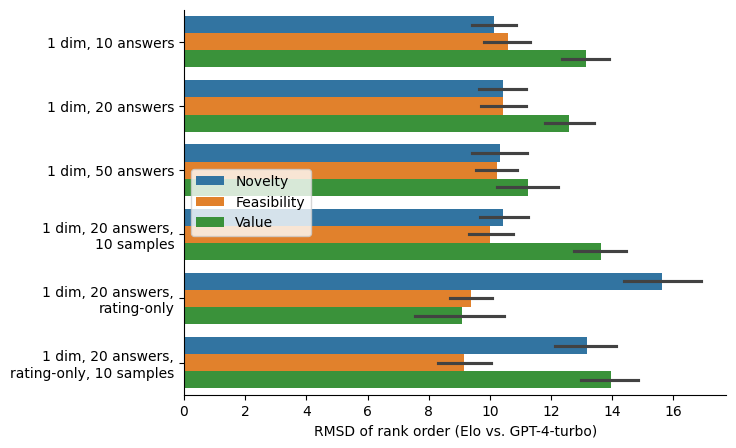

In [57]:
plt.figure(figsize=(7,5))
long = rmsd.set_index('method').melt(value_name='RMSD of rank order (Elo vs. GPT-4-turbo)', var_name='measure', ignore_index=False)
long.index = [s.replace('\n',', ').replace('answers, ','answers,\n') for s in long.index]
ax = sns.barplot(long, y=long.index, x='RMSD of rank order (Elo vs. GPT-4-turbo)', hue='measure')
plt.legend(ax.containers, [m.capitalize() for m in measures], loc='center left')
sns.despine()
plt.ylabel('')

In [58]:
pearson

,novelty,feasibility,value
1 dim\n10 answers,0.586729,0.529324,0.158902
1 dim\n20 answers,0.545021,0.547986,0.161774
1 dim\n50 answers,0.524144,0.551987,0.146895
1 dim\n20 answers\n10 samples,0.546258,0.576869,0.136647
1 dim\n20 answers\nrating-only,0.026144,0.629994,0.088002
1 dim\n20 answers\nrating-only\n10 samples,0.231466,0.674618,0.055106


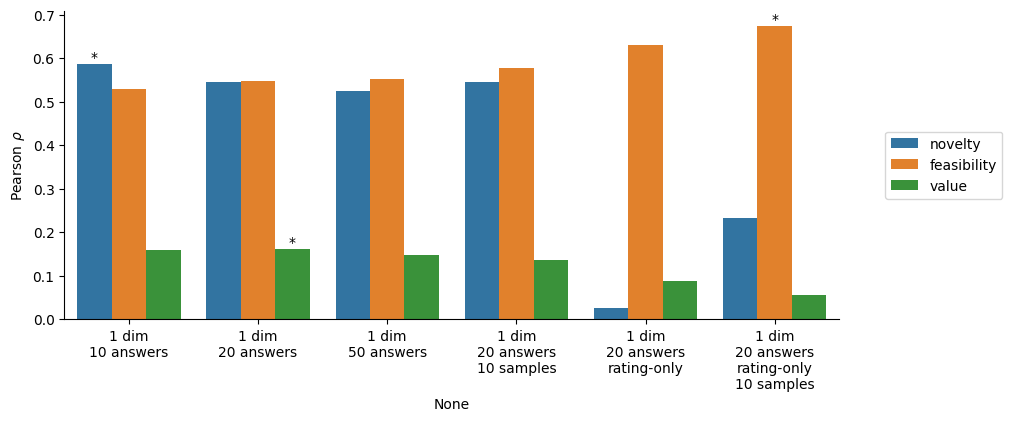

In [59]:
fig, ax = plt.subplots(figsize=(10,4))

long = pearson.melt(value_name='correlation', var_name='measure', ignore_index=False)

imax = [i*len(pearson) + pearson[col].astype('float').argmax() for i, col in enumerate(pearson.columns)]
labels = ['*' if i in imax else '' for i in range(len(long))]

sns.barplot(long, x=long.index, y='correlation', hue='measure', ax=ax)
for i, col in enumerate(pearson.columns):
    jmax = pearson[col].astype('float').argmax()
    labels = ['*' if j == jmax else '' for j in range(len(pearson))]
    ax.bar_label(ax.containers[i], labels)
ax.legend(loc='center left', bbox_to_anchor=(1.05, 0.5), ncol=1)
ax.set_ylabel('Pearson $\\rho$')
sns.despine(ax=ax)


In [60]:
spearman

,novelty,feasibility,value
1 dim\n10 answers,0.599195,0.563990,0.225352
1 dim\n20 answers,0.573114,0.582324,0.209022
1 dim\n50 answers,0.557837,0.594829,0.217460
1 dim\n20 answers\n10 samples,0.584326,0.609245,0.162272
1 dim\n20 answers\nrating-only,0.062225,0.663177,0.156584
1 dim\n20 answers\nrating-only\n10 samples,0.338335,0.684563,0.262958


In [61]:
mean = spearman_qid.groupby('method').mean()

In [62]:
std = spearman_qid.groupby('method').std()

In [63]:
print('\t'.join(['Method'] + [m.capitalize() for m in measures]))
for method in methods.values():
    m = method.replace('\n', ', ')
    print(m, end='')
    for measure in measures:
        mean_, sd_ = mean.loc[method, measure], std.loc[method, measure]
        print(f'\t{mean_:.2f}\t{sd_:.2f}\t{mean_/sd_:.2f}', end='')
    print()

Method	Novelty	Feasibility	Value
1 dim, 10 answers	0.62	0.13	4.95	0.59	0.14	4.15	0.26	0.18	1.41
1 dim, 20 answers	0.60	0.15	4.10	0.59	0.15	3.83	0.26	0.18	1.48
1 dim, 50 answers	0.61	0.14	4.32	0.61	0.16	3.87	0.30	0.20	1.51
1 dim, 20 answers, 10 samples	0.60	0.14	4.32	0.63	0.13	4.77	0.21	0.22	0.92
1 dim, 20 answers, rating-only	0.07	0.39	0.17	0.67	0.11	5.89	0.24	0.26	0.89
1 dim, 20 answers, rating-only, 10 samples	0.34	0.28	1.25	0.69	0.12	5.58	0.29	0.19	1.49
